In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
# Descargar datos
data = yf.download('BHP', start='2020-01-01', end='2023-12-31')

[*********************100%%**********************]  1 of 1 completed


In [3]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000,1.006000e+03
mean,55.894084,56.406545,55.375490,55.936302,50.827592,3.252849e+06
std,8.988175,9.036764,8.952654,9.030858,9.003104,1.755506e+06
min,27.448708,28.483498,26.565565,27.591436,24.029583,6.951320e+05
25%,49.259590,49.734613,48.777876,49.275001,43.825513,2.195674e+06
50%,57.545000,58.067114,57.152702,57.693703,53.218954,2.796951e+06
75%,62.395001,62.900002,61.903062,62.382500,57.692253,3.762441e+06
max,72.720787,73.211418,72.033897,72.256912,67.587662,1.353843e+07


In [4]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,49.259590,49.304192,48.867085,48.991970,41.455849,1382193
2020-01-03,48.385368,48.911686,48.349689,48.661907,41.176559,1208438
2020-01-06,48.519180,48.706512,48.501339,48.608383,41.131268,771584
2020-01-07,48.438892,48.795719,48.429974,48.608383,41.131268,1014393
2020-01-08,48.795719,49.063335,48.706512,48.849243,41.335075,1317848


In [5]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-12-22,68.000000,68.169998,67.669998,67.820000,66.152298,1896800
2023-12-26,68.000000,68.449997,67.959999,68.220001,66.542465,1390200
2023-12-27,68.239998,68.989998,68.230003,68.889999,67.195984,2339200
2023-12-28,68.839996,69.110001,68.580002,68.620003,66.932625,1949500
2023-12-29,68.330002,68.550003,68.010002,68.309998,66.630249,1555200


In [6]:
correlation_matrix = data.corr()
correlation_matrix

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.998840,0.998844,0.997341,0.974658,-0.135843
High,0.998840,1.000000,0.998768,0.998924,0.975599,-0.125362
Low,0.998844,0.998768,1.000000,0.998779,0.976553,-0.148868
Close,0.997341,0.998924,0.998779,1.000000,0.976628,-0.134759
Adj Close,0.974658,0.975599,0.976553,0.976628,1.000000,-0.149515
Volume,-0.135843,-0.125362,-0.148868,-0.134759,-0.149515,1.000000


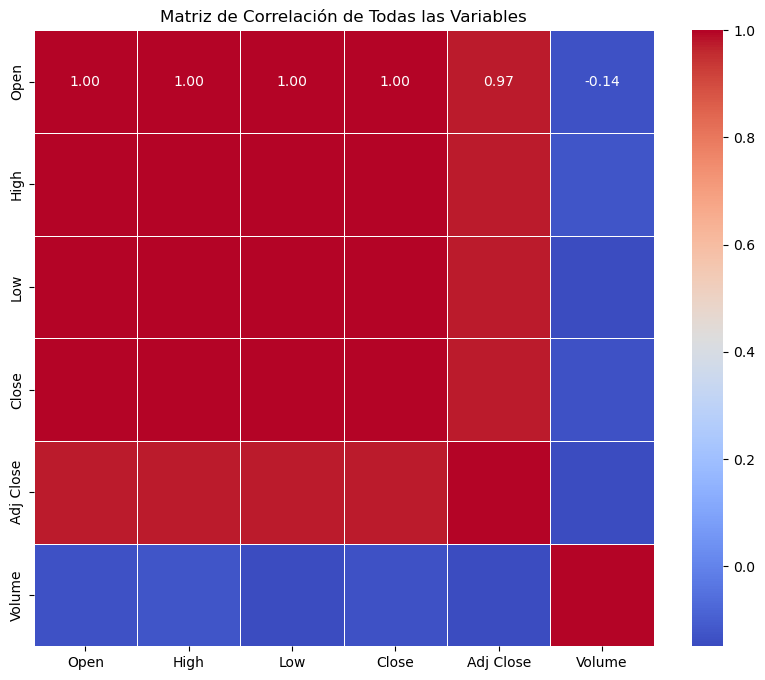

In [7]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlación de Todas las Variables')
plt.show()

In [8]:
# Crear la variable objetivo
data['Price_Change'] = data['Adj Close'].diff()
data['Target'] = (data['Price_Change'] > 0).astype(int)

In [9]:
# Preparar los datos
data['Lag_1'] = data['Adj Close'].shift(1)

In [10]:
data.dropna(inplace=True)

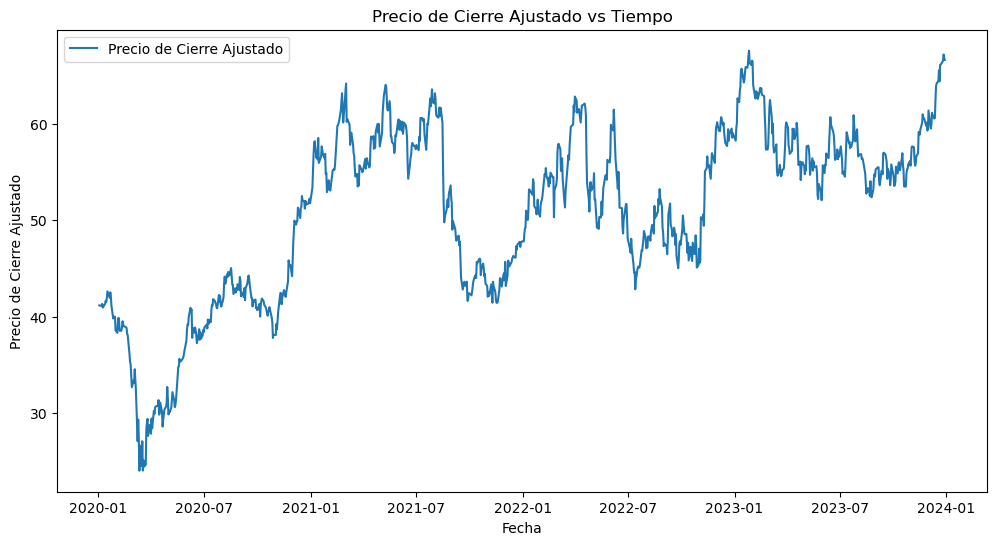

In [11]:
# 1. Gráfico del precio (Closing Price vs Time)
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Adj Close'], label='Precio de Cierre Ajustado')
plt.title('Precio de Cierre Ajustado vs Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre Ajustado')
plt.legend()
plt.show()

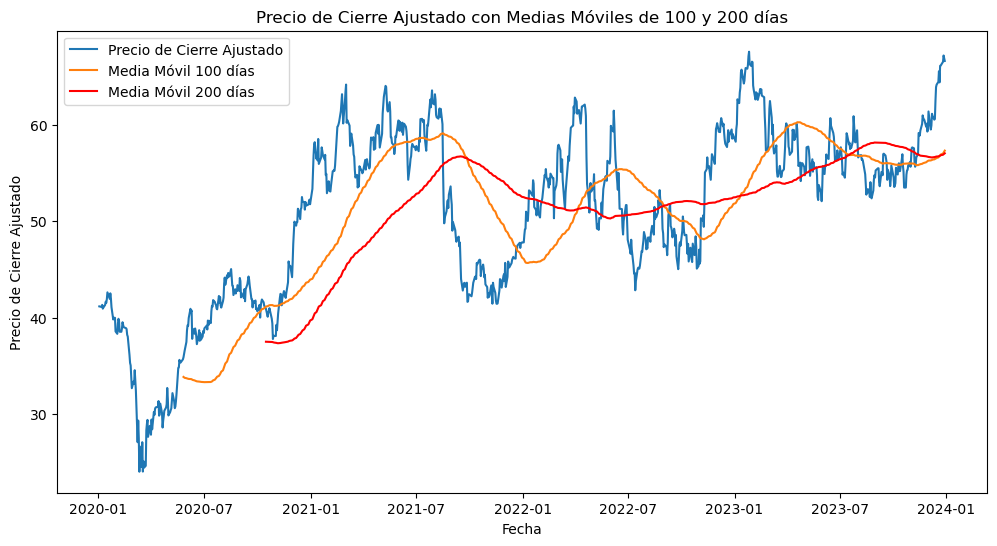

In [12]:
# 3. Gráfico de Closing Price vs Time con 100MA & 200MA
data['100MA'] = data['Adj Close'].rolling(window=100).mean()
data['200MA'] = data['Adj Close'].rolling(window=200).mean()
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Adj Close'], label='Precio de Cierre Ajustado')
plt.plot(data.index, data['100MA'], label='Media Móvil 100 días')
plt.plot(data.index, data['200MA'], label='Media Móvil 200 días', color='red')
plt.title('Precio de Cierre Ajustado con Medias Móviles de 100 y 200 días')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre Ajustado')
plt.legend()
plt.show()

In [13]:
X = data[['Lag_1']]  # Puedes añadir más características relevantes aquí
y = data['Target']

In [14]:
# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
from sklearn.model_selection import GridSearchCV

In [17]:
# Crear y entrenar el modelo SVC con búsqueda de hiperparámetros
param_grid = {'C': [0.1, 1, 10], 'gamma': [0.1, 1, 10], 'kernel': ['rbf', 'poly', 'sigmoid']}
svc_model = GridSearchCV(SVC(), param_grid, cv=5)
svc_model.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.1, 1, 10],
                         'kernel': ['rbf', 'poly', 'sigmoid']})

In [18]:
# Hacer predicciones
y_pred = svc_model.predict(X_test_scaled)

In [19]:
# Evaluar el modelo
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[26 74]
 [20 81]]
              precision    recall  f1-score   support

           0       0.57      0.26      0.36       100
           1       0.52      0.80      0.63       101

    accuracy                           0.53       201
   macro avg       0.54      0.53      0.49       201
weighted avg       0.54      0.53      0.50       201



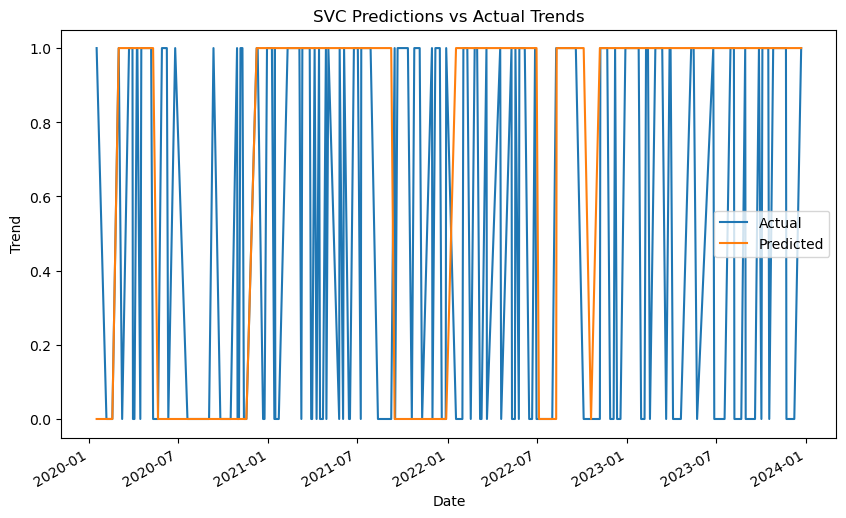

In [20]:
# Visualización de los resultados
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=y_test.index)
results['Actual'].plot(label='Actual', figsize=(10, 6))
results['Predicted'].plot(label='Predicted')
plt.title('SVC Predictions vs Actual Trends')
plt.xlabel('Date')
plt.ylabel('Trend')
plt.legend()
plt.show()

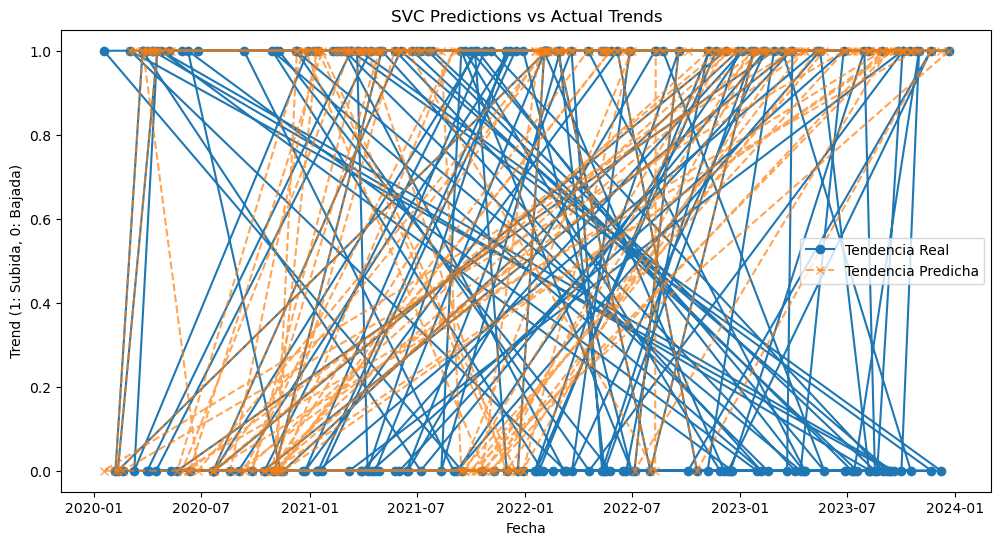

In [21]:
# 5. Precio Predicho vs Precio Original (Tendencias)
plt.figure(figsize=(12, 6))
plt.plot(results.index, results['Actual'], label='Tendencia Real', marker='o')
plt.plot(results.index, results['Predicted'], label='Tendencia Predicha', alpha=0.7, linestyle='--', marker='x')
plt.title('SVC Predictions vs Actual Trends')
plt.xlabel('Fecha')
plt.ylabel('Trend (1: Subida, 0: Bajada)')
plt.legend()
plt.show()

In [22]:
# Predicción para el siguiente día
last_price_scaled = scaler.transform([[data['Adj Close'].iloc[-1]]])
next_day_prediction = svc_model.predict(last_price_scaled)
trend = "subida" if next_day_prediction[0] == 1 else "bajada"
print(f"El precio de BHP tiene una tendencia de {trend} para el siguiente día.")

El precio de BHP tiene una tendencia de subida para el siguiente día.


C:\Users\harol\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
